#Introduction

Target Marketing for Canadian Bank.

## Scenario
A bank is looking increase its deposit balances and therefore wants to execute a marketing campaign to do so. It is planning on offering existing customers a promotional rate with the hopes of acquiring greater deposits.

Therefore, the bank is looking to develop a model that would predict which of its customers can it target successfully.

This is a binary classification problem where the model is trained to predict which cutsomers are most likely to respond successfully to the campaign

## Data Overview

The following descriptions for the different fields of data are provided on Kaggle:

### Data fields:
1.   **customer_id** - an anonymous id unique to a given customer
2.   **Balance** : - Current + Savings Account Balance
3.   **PreviousCampaignResult** - Last Campaign Results
4.   **Balance** : - Current + Savings Account Balance
5.   **PreviousCampaignResult** - Last Campaign Results
6.   **Product1...Product6** - List of different products owned by the customer
7.   **Transaction1...Transaction9** - Last 9 transactions made by the customer
8.   **External Accounts 1...External Accounts 7** - External accounts held by the customer, including bills
9.   **Activity Indicator** - Number of activities done the customer, including telebanking, going to the bank
10.   **Regular Interaction Indicator** - How frequent the customer is interacting with the bank (Rating Scale)
11.  **CompetitiveRate1 ... CompetitiveRate7** - Interest rates offered to the customer
12.  **RateBefore** - Interest rates on the products, customer have before the competitive rates being offered
13. **ReferenceRate** -Interest rates on the products, the customer have after the negotiations made to the competitive rates being offered



In addition to the data above, in the training set, we are also provided the **Target** data which is a binary field or 0 or 1 indicating whether the customer took the offer or not.


## Notebook breakdown
The notebook is broken down into four sections.
1. Setups and Data analysis
2. Feature Engineering
3. Model training and Selection
4. Final Logistic Regression Pipeline

# 1. Setups and Data Analaysis

The following are the imports and functions that are used later in the notebook for the different analyses and modelling.

## Imports and Setups

In [ ]:
# The follow cell is calling all of the imports utilized throughout the notebook

# Base data handling imports
import math
import numpy as np
import pandas as pd
from pandas import DataFrame
import pandas.io.sql as psql
from pandas.tseries.offsets import MonthEnd

# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import re

# Sci-kit Learn imports for modellng.
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
import scipy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder,scale, StandardScaler
from sklearn.decomposition import PCA

import random

# Models and Performance Measurement Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from  sklearn.metrics import precision_recall_fscore_support,precision_recall_curve,roc_curve
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn import svm,tree
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import IsolationForest
from sklearn import tree
from IPython.display import HTML

from scipy import stats

# Import for Colab to import/export
from google.colab import drive
from google.colab import files

from tensorflow import keras
import tensorflow as tf

pd.options.display.max_rows = 8
random_seed=123 # Defining/Setting the random seed
cv_fold=5 # Defining/setting the crossvalidation folds
idx=1

x_class_names = ['Predicted 0','Predicted 1']
y_class_names = ['Actual 0','Actual 1']

In [ ]:
# Defining Neural Network for DNN model training
def build_model(n_hidden=1, n_neurons=30):
    model = keras.models.Sequential()
    # options = {"input_shape": 14}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(),metrics=["accuracy"])
    return model

In [ ]:
# Defining the function to plot the confusion matrices for the Predictions
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, xclasses,yclasses,index,title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(idx)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(xclasses))
    plt.xticks(tick_marks, xclasses, rotation=45)
    plt.yticks(tick_marks, yclasses)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Defining function to display feature importance of our Random Forest Classifiers
def viz_importance(importances,feat_names):
    # Displaying the feature importances as a chart by sorting it in the order of importances
    indices = np.argsort(importances)[::-1]

    # Printing important features in the model
    df_importance=pd.DataFrame(data=[importances[indices]],columns=feat_names[indices])
    display(HTML(df_importance.to_html(index=False)))

    plt.figure(20)
    plt.figure(figsize=(12,6))
    plt.title("Feature importances - RFC")
    plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
    plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
    plt.xticks(range(len(indices)), feat_names[indices], rotation='horizontal',fontsize=8)
    plt.xlim([-1, len(indices)])
    plt.show()

In [ ]:
# Defining function to display feature importance of our Logistic Regression models
def viz_importance_LR(importances,feat_names):
    # Displaying the feature importances as a chart by sorting it in the order of importances
    indices = np.argsort(abs(importances))[::-1]

    # Printing important features in the model
    df_importance=pd.DataFrame(data=[importances[indices]],columns=feat_names[indices])
    display(HTML(df_importance.to_html(index=False)))

    plt.figure(20)
    plt.figure(figsize=(12,6))
    plt.title("Feature importances - LR")
    plt.bar(range(len(indices)), abs(importances[indices]), color='lightblue',  align="center")
    plt.step(range(len(indices)), np.cumsum(abs(importances[indices])), where='mid', label='Cumulative')
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=8)
    plt.xlim([-1, len(indices)])
    plt.show()


In [ ]:
# Defining function to measure our models' performances (precision, recall etc)
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum()
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

## Data Import and basic analyses and checks

In [ ]:
# Mounting our google drive and importing the csv file
from google.colab import drive
drive.mount('/content/gdrive')
filePath ="/content/gdrive/My Drive/3253 ML Project - Group 8/train.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Creating a Pandas Dataframe from csv file and viewing the top 5 rows
import pandas as pd
df_raw = pd.read_csv(filePath)
df_raw.head()

,Customer_id,Target,Balance,PreviousCampaignResult,Product1,Product2,Product3,Product4,Product5,Product6,Transaction1,Transaction2,Transaction3,Transaction4,Transaction5,Transaction6,Transaction7,Transaction8,Transaction9,ExternalAccount1,ExternalAccount2,ExternalAccount3,ExternalAccount4,ExternalAccount5,ExternalAccount6,ExternalAccount7,ActivityIndicator,RegularInteractionIndicator,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7,RateBefore,ReferenceRate
0,CTSP000001,0,43824.59,0,0,0,0,0,0,0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
1,CTSP000002,1,11256.21,0,0,0,0,0,0,0,0.00,0.0,0.0,8525.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,1,0,11,3,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
2,CTSP000003,1,18795.11,0,1,1,0,0,0,0,13422.35,800.0,0.0,0.0,0.0,13123.28,0.0,0.0,0.0,0,0,0,0,0,0,0,6,0,1.425,2.375,1.425,1.675,2.375,1.675,1.575,1.675,1.375
3,CTSP000004,0,22274.72,0,0,0,0,0,0,0,0.00,0.0,0.0,1000.0,23900.0,0.00,0.0,0.0,0.0,0,0,0,0,0,1,0,14,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
4,CTSP000005,0,47923.40,0,1,0,0,0,0,0,0.00,0.0,0.0,0.0,2000.0,27629.11,0.0,0.0,0.0,0,1,0,0,0,0,0,2,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375


In [ ]:
# Checking number of rows and columns
df_raw.shape

(63999, 37)

In [ ]:
# Checking the column data types
list_data = df_raw.dtypes

In [ ]:
# Printing the column data types
print(list_data)

Customer_id                object
Target                      int64
Balance                   float64
PreviousCampaignResult      int64
                           ...   
CompetitiveRate6          float64
CompetitiveRate7          float64
RateBefore                float64
ReferenceRate             float64
Length: 37, dtype: object


In [ ]:
# Making of a copy of the raw data for analysis and engineering
df=df_raw.copy(deep=True)

In [ ]:
# Checking for N/A values
print (f'\033[31m > # of N/As: \033[31m' )
if df.isnull().values.sum()==0:
    print(f'\033[32m No N/A \033[32m')
else:
    for column_name,column in df.transpose().iterrows():
        if df.isnull()[column_name].values.sum() !=0:
            print(f'\033[32m Number of error in column {column_name}: {df.isnull()[column_name].values.sum():,} \033[32m')

 > # of N/As: 
 No N/A 


In [ ]:
# Checking to make sure no customer ids are duplicated
df.loc[df.Customer_id.duplicated(),:].shape[0]

0

In [ ]:
# Reviewing the general description statistics of the numerical columns
df.describe()

,Target,Balance,PreviousCampaignResult,Product1,Product2,Product3,Product4,Product5,Product6,Transaction1,Transaction2,Transaction3,Transaction4,Transaction5,Transaction6,Transaction7,Transaction8,Transaction9,ExternalAccount1,ExternalAccount2,ExternalAccount3,ExternalAccount4,ExternalAccount5,ExternalAccount6,ExternalAccount7,ActivityIndicator,RegularInteractionIndicator,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7,RateBefore,ReferenceRate
count,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,6.399900e+04,6.399900e+04,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000
mean,0.499773,22697.014218,0.001484,0.200441,0.160456,0.001766,0.092158,0.022125,0.041876,312.852441,98.306560,972.439108,13346.706243,5.872490e+03,8.831981e+03,101.191833,1522.355254,1123.682674,0.197034,0.301911,0.082533,0.123783,0.191862,0.100423,0.019313,19.776778,0.595291,1.379736,1.836435,1.391770,1.757322,1.882755,1.678434,1.412233,1.678434,1.315226
std,0.500004,10819.489043,0.039303,0.400333,0.367031,0.041983,0.289251,0.147092,0.200307,4932.061568,897.296635,5903.126316,25046.228309,2.226038e+04,3.051680e+04,894.873343,7410.544303,9570.708952,0.397762,0.459090,0.275176,0.329337,0.393768,0.300566,0.137623,104.827436,1.162643,0.206340,0.370122,0.161833,0.357483,0.516006,0.160600,0.575083,0.160600,0.106634
min,0.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-34.340000,-33813.000000,0.000000e+00,-2.092436e+04,-957.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.025000,1.425000,1.125000,1.425000,1.175000,1.425000,0.525000,1.425000,1.125000
25%,0.000000,13499.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.425000,1.575000,1.425000,1.575000,1.575000,1.675000,0.525000,1.675000,1.375000
50%,0.000000,19982.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5670.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.425000,1.925000,1.425000,1.675000,2.375000,1.675000,1.575000,1.675000,1.375000
75%,1.000000,30104.035000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17500.000000,2.000000e+03,5.500000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,1.575000,2.375000,1.575000,1.675000,2.375000,1.875000,1.575000,1.875000,1.375000
max,1.000000,50000.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,505000.000000,85500.000000,633506.040000,917005.000000,1.330000e+06,2.029492e+06,36186.980000,297055.190000,513627.920000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6762.000000,56.000000,1.575000,2.375000,1.575000,2.375000,2.375000,1.875000,2.125000,1.875000,1.375000


In [ ]:
# getting the basic descriptive statistics for the Categorical columns.
df.describe(include=['datetime64','O'])

,Customer_id
count,63999
unique,63999
top,CTSP053654
freq,1


As it can be seen by the descriptive statistics above, quite a few of the columns data is zero. In fact, several of the columns are more than 75% zero. In addition, by looking at the mean of some of the binary fields like the product fields, you can see that most of the values in the column are zero. For example, the mean for Product 3 is 0.001766 meants only 0.1766% of the customers have product 3.

Due to the low mean of some of the binary fields compared to the target, we suspect that they will not be as important to the model.

## Correlations

Lets see if there are any correlations that can be picked within the different categories of the raw data. Due to the large number of features, we are grouping some of the features into different Dataframes and comparing the correlations within.

In [ ]:
# Creating a dataframe for the Transactions to look for correlations amongst the transactions and the Target
transactions = df[['Target','Transaction1', 'Transaction2', 'Transaction3', 'Transaction4', 'Transaction5','Transaction6', 'Transaction7', 'Transaction8', 'Transaction9']]

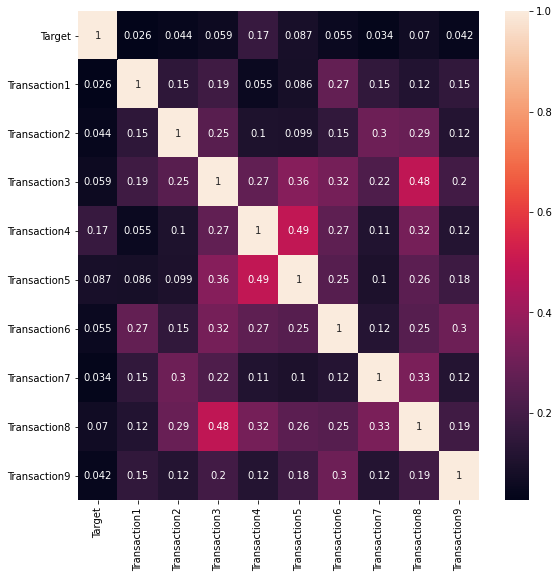

In [ ]:
plt.subplots(figsize=(9,9))
sns.heatmap(transactions.corr(), annot=True)

As can be seen on the correlation heatmap above it can be observed that only transaction 4 seems to have some correlation to the target with the others having very weak correlations. Transactions 4 and 5 and 8 and 3 are decently correlated with each other.


In [ ]:
# Creating a dataframe of the different rates to check for correclation amongst them and the target
rates = df[['Target','CompetitiveRate1', 'CompetitiveRate2', 'CompetitiveRate3', 'CompetitiveRate4', 'CompetitiveRate5', 'CompetitiveRate6', 'CompetitiveRate7', 'RateBefore', 'ReferenceRate']]

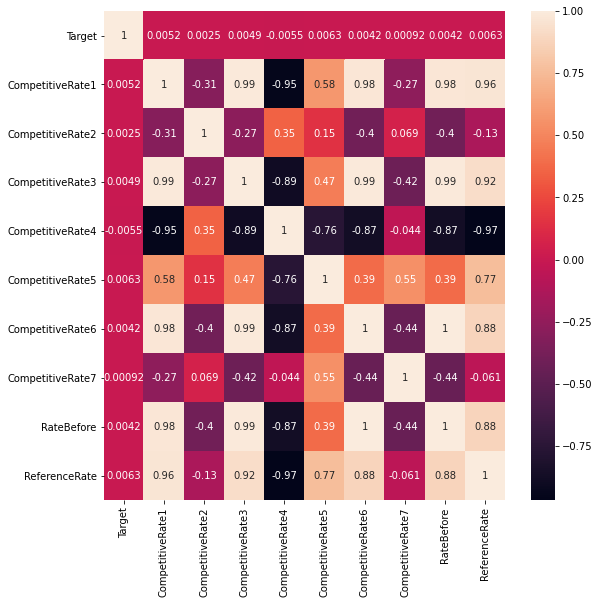

In [ ]:
plt.subplots(figsize=(9,9))
sns.heatmap(rates.corr(), annot=True)

As you can see in the heatmap above, there are some strong correlations between some of the rates (both close to 1 and -1). This could be attributed to the fact that the different customers might be bucketed into different categories which gives them a certain promotional rate and with the different campaigns the promo rates go up or down and every customer's offer goes up or down by a specific amount

There is one concern we have however: Competititve Rate 6 has a correlation of 1 with Rate Before. Upon detailed analysis we found that the rates are the same so we will be dropping Competitive rate 6 during feature engineering to prevent the risk of overfitting.

In [ ]:
# Creating a dataframe of the Products to look at correlations between the different products and the target
products = df[['Target','Product1','Product2','Product3', 'Product4', 'Product5', 'Product6']]

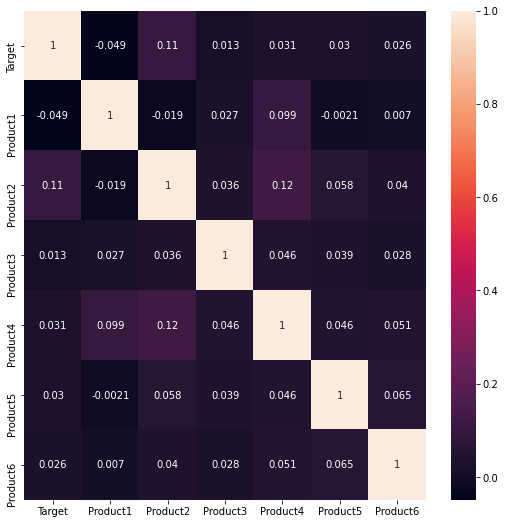

In [ ]:
plt.subplots(figsize=(9,9))
sns.heatmap(products.corr(), annot=True)

The product features have very little correlation with one another and very little with the target itself (the highest reaching a mere 0.11).

In [ ]:
# Creating a dataframe of the External Accounts to look at correlations between the different external accounts and the target
ext_accounts = df[['Target', 'ExternalAccount1', 'ExternalAccount2', 'ExternalAccount3', 'ExternalAccount4', 'ExternalAccount5', 'ExternalAccount6', 'ExternalAccount7']]

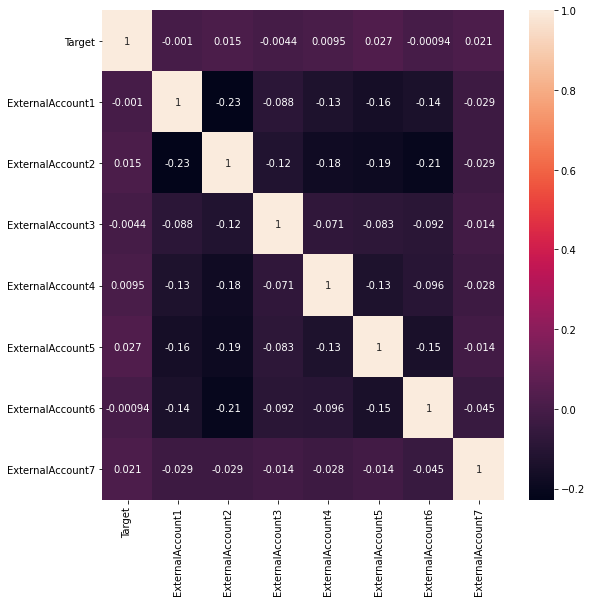

In [ ]:
plt.subplots(figsize=(9,9))
sns.heatmap(ext_accounts.corr(), annot=True)

## Target Analysis

In [ ]:
# Checking the response rate of the campaign in the training data
df_respond_rate=df[['Target']].groupby(['Target']).agg({'Target':'count'})
df_respond_rate['%']=df_respond_rate['Target']/len(df['Target'])*100
print (f'\033[31m > Responding Rate% \033[0m' )
print(df_respond_rate)

 > Responding Rate% 
        Target          %
Target                   
0        32014  50.022657
1        31985  49.977343


# 2. Feature engineering and and detailed analysis

In the following section, we start detailed analysis of the different features in the raw data and conduct feature engineering.

You will notice below that we are binning several of our features. This is due to the wide range of data but most of the distribution near zero.

In [ ]:
# Taking total sum of Products and Accounts for each customer
df.drop(['Product_Sum','ExternalAccount_Sum'],axis=1,inplace=True, errors='ignore')
df['Product_Sum']=df[df.filter(like='Product').columns].sum(axis = 1)
df['ExternalAccount_Sum']=df[df.filter(like='ExternalAccount').columns].sum(axis = 1)

In [ ]:
# Flooring to minimize noise and impove the fit for the transactions
trans_floor=50

df.drop(df.filter(like='Transaction_').columns,axis=1,inplace=True, errors='ignore')
df_trans=df[df.filter(like='Transaction').columns]
df['Transaction_Sum']=df_trans.sum(axis = 1)
df['Transaction_Min']=df_trans[(df_trans >trans_floor)].min(axis=1)
df['Transaction_Min'] = df['Transaction_Min'].fillna(10)
df['Transaction_Max']=df_trans.max(axis=1)
df['Transaction_Mean']=df_trans.mean(axis=1)
df['Transaction_Median']=df_trans[(df_trans >trans_floor)].median(axis=1)
df['Transaction_Median'] = df['Transaction_Median'].fillna(0)
df['Transaction_Std']=df_trans[(df_trans >trans_floor)].std(axis=1)
df['Transaction_Std'] = df['Transaction_Std'].fillna(0)
df['Transaction_Count']=df_trans[(df_trans >trans_floor)].count(axis=1)

In [ ]:
# Dropping Competitive Rates 6 as mentioned before due to a correlation of 1 with the Rate Before and upon further investigation, we found that the rates are the same
df['Rate_Drop'] = df['RateBefore'].sub(df['ReferenceRate'], axis = 0)
df.drop(['CompetitiveRate6'],axis=1,inplace=True, errors='ignore')

In [ ]:
# Creating a feature comparing Rate 4 to Rate Before and Rate 3 to Reference Rate due to strong correlations
df['R4EqBefore']=0
df.loc[df.CompetitiveRate4==df.RateBefore,'R4EqBefore']=1
df['R3EqRef']=0
df.loc[df.CompetitiveRate3==df.ReferenceRate,'R3EqRef']=1

## Binning

We are binning data as mentioned before. You will see a graph showing the normal data distribution and the binned distribution.

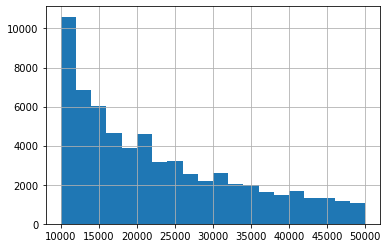

In [ ]:
# Checking the distribution of the balance
df['Balance'].hist(bins=20)

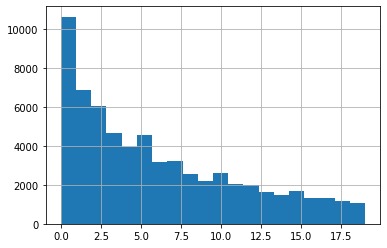

In [ ]:
# Grouping the Balance into multiple bins
cut_bins = [-np.inf,0, 50, 100, 200, 400, 800, 1600, 3200, 6400,12800, np.inf]
df['Balance_Bin'] = pd.cut(df['Balance'], bins=20, labels=False,right=True)
df['Balance_Bin'].hist(bins=20)

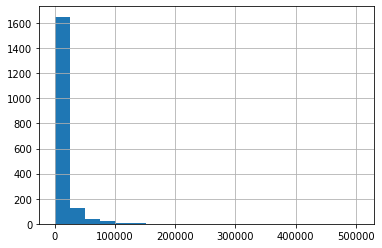

In [ ]:
df.loc[df.Transaction1>0,'Transaction1'].hist(bins=20)

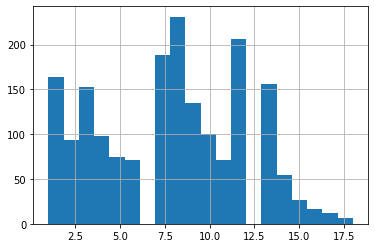

In [ ]:
# Bining the Tranasactions into 20 categories
# Tried to bin them by percentage and percentile however that did not help. Therefore we use fixed values to bin them into categories.
cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction1_Bin'] = pd.cut(df['Transaction1'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction1>0,'Transaction1_Bin'].hist(bins=20)

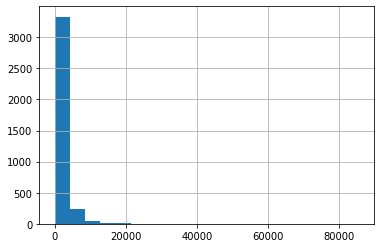

In [ ]:
df.loc[df.Transaction2>0,'Transaction2'].hist(bins=20)

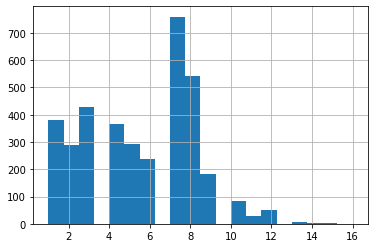

In [ ]:
cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction2_Bin'] = pd.cut(df['Transaction2'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction2>0,'Transaction2_Bin'].hist(bins=20)

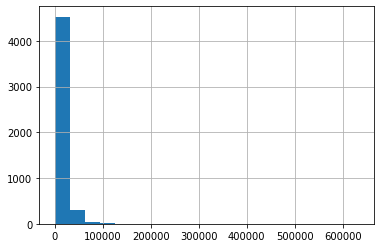

In [ ]:
df.loc[df.Transaction3>0,'Transaction3'].hist(bins=20)

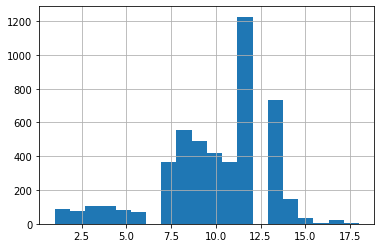

In [ ]:
cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction3_Bin'] = pd.cut(df['Transaction3'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction3>0,'Transaction3_Bin'].hist(bins=20)

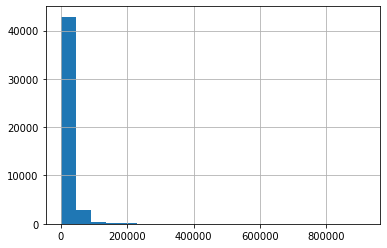

In [ ]:
df.loc[df.Transaction4>0,'Transaction4'].hist(bins=20)

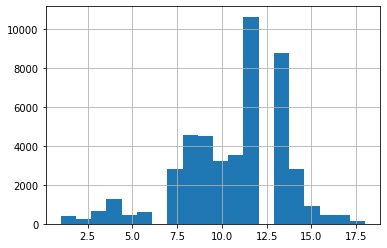

In [ ]:
cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction4_Bin'] = pd.cut(df['Transaction4'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction4>0,'Transaction4_Bin'].hist(bins=20)

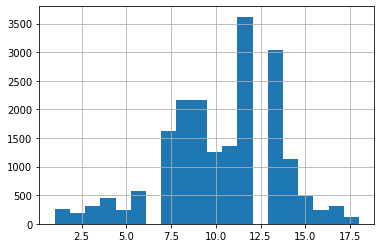

In [ ]:
df['Transaction5_Bin'] = pd.cut(df['Transaction5'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction5>0,'Transaction5_Bin'].hist(bins=20)

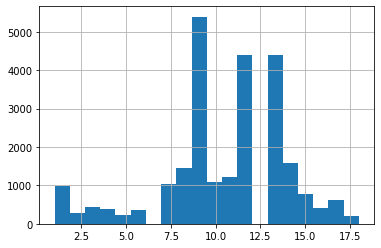

In [ ]:
df['Transaction6_Bin'] = pd.cut(df['Transaction6'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction6>0,'Transaction6_Bin'].hist(bins=20)

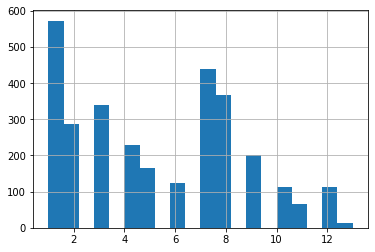

In [ ]:
df['Transaction7_Bin'] = pd.cut(df['Transaction7'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction7>0,'Transaction7_Bin'].hist(bins=20)

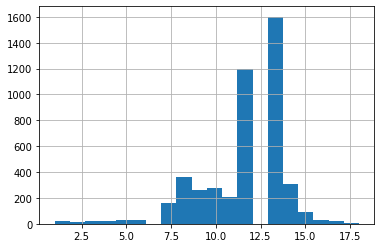

In [ ]:
df['Transaction8_Bin'] = pd.cut(df['Transaction8'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction8>0,'Transaction8_Bin'].hist(bins=20)

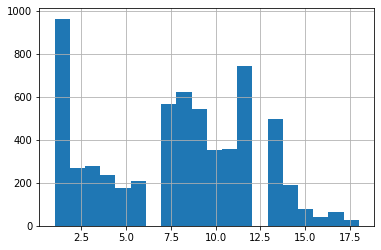

In [ ]:
df['Transaction9_Bin'] = pd.cut(df['Transaction9'], bins=cut_bins, labels=False,right=True)
df.loc[df.Transaction9>0,'Transaction9_Bin'].hist(bins=20)

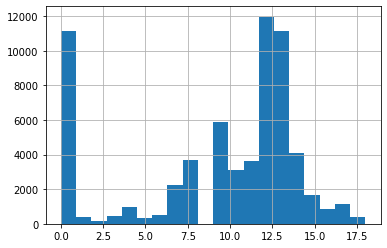

In [ ]:
df['Transaction_Max_Bin'] = pd.cut(df['Transaction_Max'], bins=cut_bins, labels=False,right=True)
df.loc[:,'Transaction_Max_Bin'].hist(bins=20)

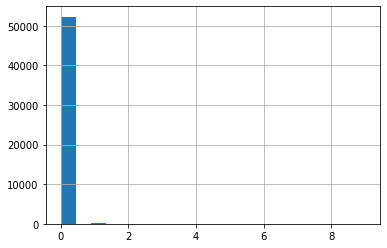

In [ ]:
df['Transaction_Min_Bin'] = pd.cut(df['Transaction_Min'], bins=10, labels=False,right=True)
df.loc[df.Transaction_Min>50,'Transaction_Min_Bin'].hist(bins=20)

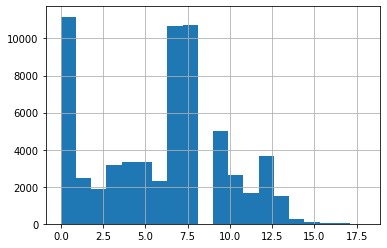

In [ ]:
df['Transaction_Mean_Bin'] = pd.cut(df['Transaction_Mean'], bins=cut_bins, labels=False,right=True)
df.loc[:,'Transaction_Mean_Bin'].hist(bins=20)

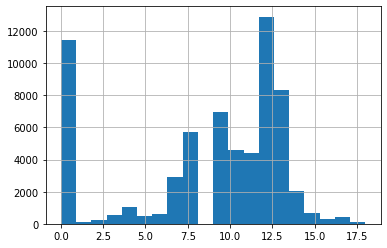

In [ ]:
df['Transaction_Median_Bin'] = pd.cut(df['Transaction_Median'], bins=cut_bins, labels=False,right=True)
df.loc[:,'Transaction_Median_Bin'].hist(bins=20)

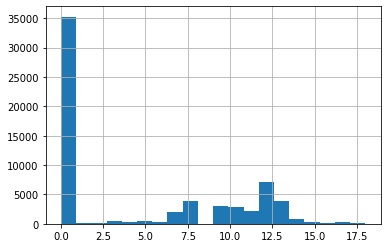

In [ ]:
df['Transaction_Std_Bin'] = pd.cut(df['Transaction_Std'], bins=cut_bins, labels=False,right=True)
df.loc[:,'Transaction_Std_Bin'].hist(bins=20)

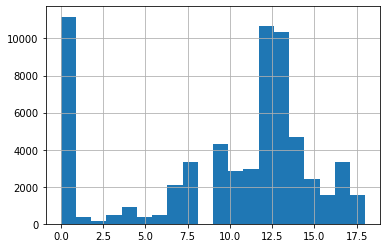

In [ ]:
df['Transaction_Sum_Bin'] = pd.cut(df['Transaction_Sum'], bins=cut_bins, labels=False,right=True)
df.loc[:,'Transaction_Sum_Bin'].hist(bins=20)

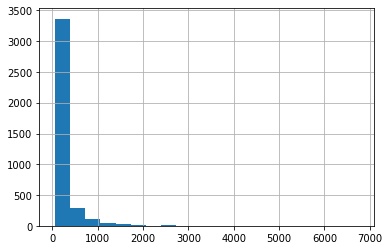

In [ ]:

df.loc[df.ActivityIndicator>50,'ActivityIndicator'].hist(bins=20)

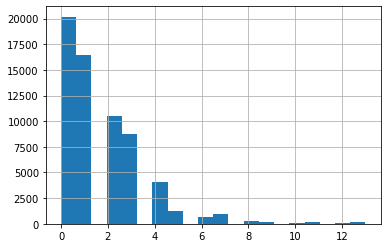

In [ ]:
cut_bins = [-np.inf,0, 5, 10, 25, 50,75,100, 200,300,400,500,750,1000,np.inf]
df['ActivityIndicator_Bin'] = pd.cut(df['ActivityIndicator'], bins=cut_bins, labels=False,right=True)
df.loc[:,'ActivityIndicator_Bin'].hist(bins=20)


In [ ]:
# g = sns.PairGrid(df_train)
# g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

Through testing, we were able to narrow down the number of important features to the list below

In [ ]:
# Defining the features we found the best
feature_cols=['Balance_Bin',	'ActivityIndicator_Bin',	'Transaction4_Bin',	'Transaction_Max_Bin',	'Transaction_Median_Bin',	'Transaction_Mean_Bin',	'Transaction_Sum_Bin',	'Transaction_Std_Bin',	'Transaction6_Bin',	'RegularInteractionIndicator',	'Transaction5_Bin',	'ExternalAccount_Sum',	'Transaction_Count',	'Product_Sum']

In [ ]:
# Splitting the DataFrame into X and Y.
df.reset_index(drop=True, inplace=True)
df_x=df[feature_cols]
df_y=df['Target']


df_x.shape

(63999, 14)

Since we need to train several models and test the accuarcy, precision etc, we are going to have to reduce the datasize to allow the models to be trained before the Colab connection times out.

We found that if we dont reduce the training dataset size we were timing out during testing below.

To ensure that the dataset is properly distributed, we are taking a stratified subset of the data using the StratifiedShuffleSplit function in SkLearn

In [ ]:
# Creating a stratified test sample that we will be using for testing several models at once.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=random_seed)

for train_index, test_index in sss.split(df_x, df_y):
  df_x, df_y = df_x.iloc[test_index,:], df_y.iloc[test_index]

df_x.reset_index(drop=True, inplace=True)
df_y.reset_index(drop=True, inplace=True)
df_x.shape

(6400, 14)

In [ ]:
# Shuffle the sample and split data into 7:3 between traning and testing.
x_train, x_test,y_train,y_test=train_test_split(df_x,df_y,test_size=0.3,random_state=random_seed)

train_list=x_train.index
test_list=x_test.index

scaler = StandardScaler()
x_train_std=scaler.fit_transform(x_train)
x_test_std=scaler.transform(x_test)



df_train=x_train.merge(pd.DataFrame(data=y_train), left_index=True, right_index=True)
df_train

,Balance_Bin,ActivityIndicator_Bin,Transaction4_Bin,Transaction_Max_Bin,Transaction_Median_Bin,Transaction_Mean_Bin,Transaction_Sum_Bin,Transaction_Std_Bin,Transaction6_Bin,RegularInteractionIndicator,Transaction5_Bin,ExternalAccount_Sum,Transaction_Count,Product_Sum,Target
6061,14,0,13,13,13,9,13,0,0,0,0,1,1,1,1
2885,0,2,7,13,9,9,14,12,13,0,10,1,4,2,1
2492,3,0,13,13,13,9,14,13,0,1,8,1,2,0,1
33,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4060,1,2,12,12,12,7,12,0,0,0,0,1,1,1,0
1346,15,0,0,0,0,0,0,0,0,0,0,2,0,0,0
3454,4,1,0,9,9,4,9,0,9,0,0,1,1,0,1
3582,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# 3. Model Training and Selection

## Train and Test Preparation

In [ ]:
# We tested 95% PCA. The performance is similar. Uncomment the lines to include PCA.
# pca = PCA(.95)
# x_train=pca.fit_transform(x_train)
# x_test=pca.transform(x_test)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');
# pca_std = PCA(.95)
# x_train_std=pca_std.fit_transform(x_train_std)
# x_test_std=pca_std.transform(x_test_std)
# plt.plot(np.cumsum(pca_std.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [ ]:
# Generate list of algorithms
classifiers = {
    "DT": tree.DecisionTreeClassifier()
    ,"KNN": KNeighborsClassifier()
    ,"SVC": svm.SVC()
    ,"ADA": AdaBoostClassifier()
    ,"XGB": GradientBoostingClassifier()
    ,"LR": LogisticRegression()
    ,"RFC": RandomForestClassifier()
    ,"NN":keras.wrappers.scikit_learn.KerasClassifier(build_model) #Calling the DNN model here
}

# Define search space for LinearRegression
search_space_lr = {
    'penalty': ['l2'],
    'C':scipy.stats.expon(scale=100),
    'max_iter': [2000],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'random_state':[random_seed]
}


# Define search space for KNN
search_space_knn = {
    'weights':['uniform','distance'],
    'algorithm':['auto'],
    'n_neighbors':randint(2,20),
     'p':[1,2]
}

# Define search space for SVM
search_space_svc = {
    'C':scipy.stats.expon(scale=100),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':randint(1,10),
    'gamma':['auto'],
    'probability':[True],
    'random_state':[random_seed]
}

# Define search space for AdaBoostClassifier
search_space_ada = {
    'learning_rate':sp_randFloat(),
    'n_estimators': randint(5,2000),
    'algorithm': ['SAMME','SAMME.R'],
    'random_state':[random_seed]
}

# Define search space for GradientBoostingClassifier
search_space_xgb = {
    'loss':['deviance', 'exponential'],
    'learning_rate':sp_randFloat(),
    'n_estimators': randint(5,2000),
    'max_features': ['auto'],
    'random_state':[random_seed]
}


# Define search space for DecisionTreeClassifier
search_space_dt = {
    'max_depth': randint(1, 200),
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
      'min_weight_fraction_leaf':[0.01,0.03,0.05,0.08,0.1],
    'random_state':[random_seed]
}

# Define search space for RandomForestClassifier
search_space_rfc = {
    'n_estimators': randint(5,2000),
    'max_depth': randint(1, 200),
    'criterion':['gini','entropy'],
    'random_state':[random_seed]
}

search_space_nn = {
    "n_hidden": randint(0, 5),
    "n_neurons": randint(1, df.shape[1]+5)
}

# Stack up search spaces
search_space_all=[search_space_dt
                  ,search_space_knn
                  ,search_space_svc
                  ,search_space_ada
                  ,search_space_xgb
                  ,search_space_lr
                  ,search_space_rfc
                  ,search_space_nn
                 ]


# Define dictionary of search space positions
search_space_pos={'DT': 0
                ,'KNN': 1
                ,'SVC': 2
                ,'ADA': 3
                ,'XGB': 4
                ,'LR':  5
                ,'RFC': 6
                ,'NN':  7
                 }

## Model Training and Testing

112/112 [==============================] - 0s 1ms/step - loss: 0.6739 - accuracy: 0.5865
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
140/140 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.6036
Instructions for updating:
Please use `model.predict()` instead.


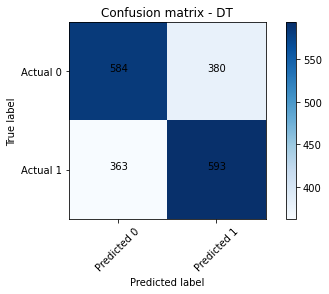

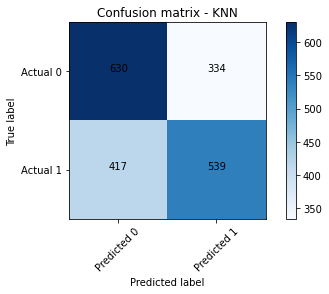

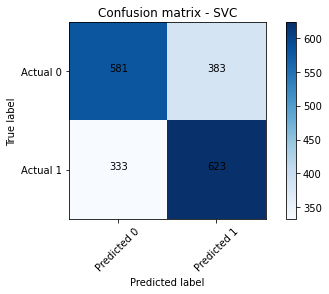

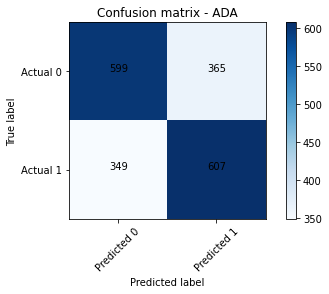

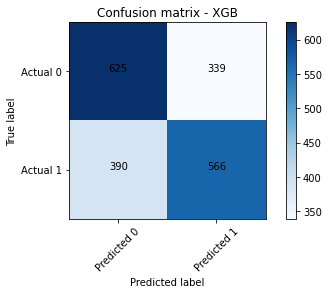

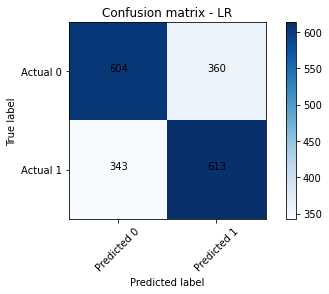

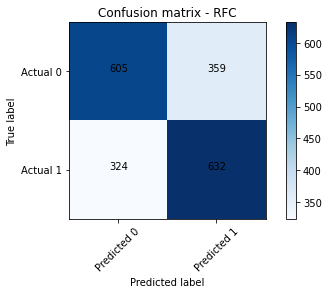

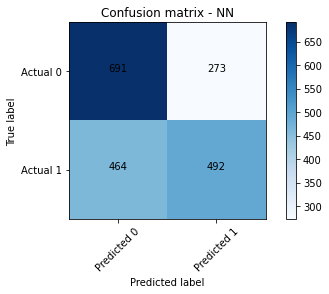

In [ ]:
# Create blank dataframes for result matrics
# Then fitting all of the models called above
tuningOutcome_All=pd.DataFrame()
probaOutlier_All=pd.DataFrame()
result_All=pd.DataFrame()
classifierTuned={}

for key, classifier in classifiers.items():
    search_space =search_space_all[search_space_pos[key]]
    if 'trained_DT' in locals():
      classifiers['ADA']=AdaBoostClassifier(trained_DT)
      classifiers['XGB']=GradientBoostingClassifier(trained_DT)
    rand_search = RandomizedSearchCV(estimator=classifier, scoring="accuracy",param_distributions=search_space,return_train_score=True)


    rand_search.fit(x_train_std,y_train)

    tuningOutcome = pd.DataFrame(rand_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
    tuningOutcome['Algorithm']=key
    tuningOutcome_All=pd.concat([tuningOutcome,tuningOutcome_All])

    # Re-run classifier with best parameters
    classifierTuned[key]= rand_search.best_estimator_
    if key == "DT":
      trained_DT=classifierTuned[key]


    classifierTuned[key].fit(x_train_std,y_train)

    # Predict class probabilities
    probaOutlier = classifierTuned[key].predict_proba(x_test_std)

    #Predict y with test set
    y_pred= classifierTuned[key].predict(x_test_std)

    # # Keep only the positive class
    # probaOutlier = [p[1] for p in probaOutlier]
    # # Append to main probability table
    # probaOutlier_All[key + "_Proba"]=probaOutlier

    # Tabulate result matrix
    result=pandas_classification_report(y_test, y_pred)
    # # Log AUROC score
    # result['AUROC']=roc_auc_score(y_test, probaOutlier)
    # Add model name
    result['Algorithm']=key
    # Append to main Result table
    result_All=pd.concat([result,result_All])


    #Defining the confusion matrix
    cm = confusion_matrix(y_test,y_pred)

    #Plotting the confusion matrix
    plot_confusion_matrix(cm, xclasses=x_class_names,yclasses=y_class_names, title='Confusion matrix - ' + key,index=idx)
    idx+=1



In [ ]:
# Defining the Voting Classifier. We tried both hard voting and soft voting. The Hard Voting gave us better results
voting_clf = VotingClassifier(
               estimators=[('LR', classifierTuned["LR"]), ('RFC', classifierTuned['RFC']), ('SVC', classifierTuned['SVC'])
               , ('ADA', classifierTuned['ADA']), ('XGB', classifierTuned['XGB'])]
              ,voting='hard')
voting_clf.fit(x_train_std,y_train)
y_pred= voting_clf.predict(x_test_std)
# Tabulate result matrix
result=pandas_classification_report(y_test, y_pred)
# # Log AUROC score
# result['AUROC']=roc_auc_score(y_test, probaOutlier)
# Add model name
result['Algorithm']='Vote'
# Append to main Result table
result_All=pd.concat([result,result_All])

In [ ]:
pd.options.display.max_rows=50
result_All

,precision,recall,f1-score,support,Algorithm
0,0.646432,0.629668,0.637940,964.0,Vote
1,0.636086,0.652720,0.644295,956.0,Vote
avg / total,0.641281,0.641146,0.641104,1920.0,Vote
0,0.598268,0.716805,0.652194,964.0,NN
1,0.643137,0.514644,0.571761,956.0,NN
avg / total,0.620609,0.616146,0.612145,1920.0,NN
0,0.651238,0.627593,0.639197,964.0,RFC
1,0.637740,0.661088,0.649204,956.0,RFC
avg / total,0.644517,0.644271,0.644180,1920.0,RFC
0,0.637804,0.626556,0.632130,964.0,LR


Findings:
  1.   With the training set: XGB is the best model
  2.   With the test set: LR is the better

Transaction_Sum_Bin,Transaction_Mean_Bin,Transaction_Max_Bin,ActivityIndicator_Bin,Balance_Bin,Transaction6_Bin,Transaction_Median_Bin,Transaction5_Bin,Transaction_Count,Transaction4_Bin,ExternalAccount_Sum,RegularInteractionIndicator,Product_Sum,Transaction_Std_Bin
-1.055536,1.012488,0.700422,0.278456,-0.213295,-0.191613,-0.11414,-0.106171,-0.105552,0.055307,0.035197,-0.026514,-0.02589,0.023437


<Figure size 432x288 with 0 Axes>

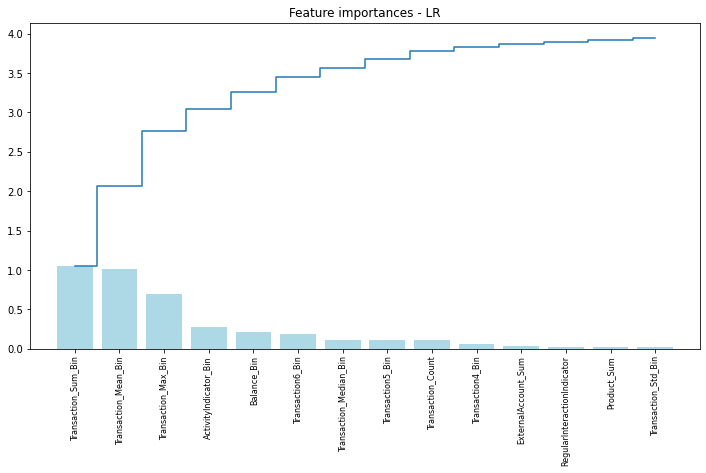

In [ ]:
# print feature importance table and graph from Logistic Regression
viz_importance_LR(np.reshape(classifierTuned["LR"].coef_, (classifierTuned["LR"].coef_.shape[1], )),df_x.columns)

Transaction4_Bin,Balance_Bin,ActivityIndicator_Bin,Transaction_Max_Bin,Transaction_Median_Bin,Transaction_Mean_Bin,Transaction_Sum_Bin,Transaction_Std_Bin,Transaction5_Bin,Transaction6_Bin,Transaction_Count,RegularInteractionIndicator,Product_Sum,ExternalAccount_Sum
0.124829,0.121277,0.120901,0.093091,0.084385,0.081559,0.073581,0.059488,0.049167,0.049071,0.038836,0.037199,0.035808,0.030808


<Figure size 432x288 with 0 Axes>

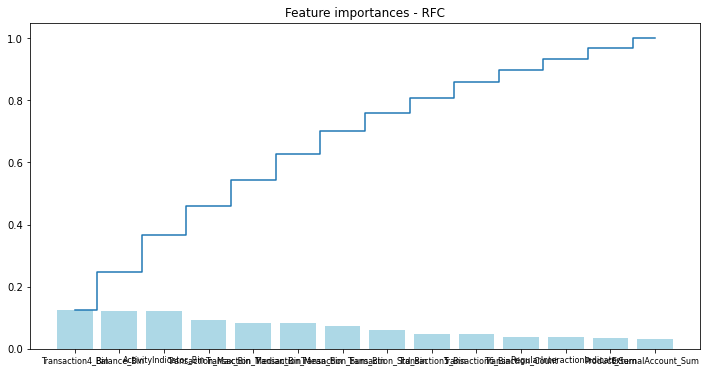

In [ ]:
# print feature importance table and graph from RFC
viz_importance(classifierTuned['RFC'].feature_importances_,x_train.columns)

## Predictions

In [ ]:
filePath ="/content/gdrive/My Drive/test.csv"
df = pd.read_csv(filePath)

# Dependent Variables
print (f'\033[31m > # of N/As: \033[31m' )
if df.isnull().values.sum()==0:
    print(f'\033[32m No N/A \033[32m')
else:
    for column_name,column in df.transpose().iterrows():
        if df.isnull()[column_name].values.sum() !=0:
            print(f'\033[32m Number of error in column {column_name}: {df.isnull()[column_name].values.sum():,} \033[32m')

df.loc[df.Customer_id.duplicated(),:].shape[0]
df.describe()
df.describe(include=['datetime64','O'])
# df['New_Customer_id'] = df.Customer_id.str[5:]

# df['New_Customer_id'] = df['New_Customer_id'].apply(pd.to_numeric)
# df['New_Customer_id']
df.drop(['Product_Sum','ExternalAccount_Sum'],axis=1,inplace=True, errors='ignore')
df['Product_Sum']=df[df.filter(like='Product').columns].sum(axis = 1)
df['ExternalAccount_Sum']=df[df.filter(like='ExternalAccount').columns].sum(axis = 1)

df.drop(df.filter(like='Transaction_').columns,axis=1,inplace=True, errors='ignore')
df_trans=df[df.filter(like='Transaction').columns]
df['Transaction_Sum']=df_trans.sum(axis = 1)
df['Transaction_Min']=df_trans[(df_trans >50)].min(axis=1)
df['Transaction_Min'] = df['Transaction_Min'].fillna(10)
df['Transaction_Max']=df_trans.max(axis=1)
df['Transaction_Mean']=df_trans.mean(axis=1)
df['Transaction_Median']=df_trans[(df_trans >50)].median(axis=1)
df['Transaction_Median'] = df['Transaction_Median'].fillna(0)
df['Transaction_Std']=df_trans[(df_trans >50)].std(axis=1)
df['Transaction_Std'] = df['Transaction_Std'].fillna(0)
df['Transaction_Count']=df_trans[(df_trans >50)].count(axis=1)
df['Rate_Drop'] = df['RateBefore'].sub(df['ReferenceRate'], axis = 0)
df.drop(['CompetitiveRate6'],axis=1,inplace=True, errors='ignore')
df['R4EqBefore']=0
df.loc[df.CompetitiveRate4==df.RateBefore,'R4EqBefore']=1
df['R3EqRef']=0
df.loc[df.CompetitiveRate3==df.ReferenceRate,'R3EqRef']=1
df.drop(['CompetitiveRate1'],axis=1,inplace=True, errors='ignore')
df.drop(['CompetitiveRate3'],axis=1,inplace=True, errors='ignore')
df.drop(['CompetitiveRate4'],axis=1,inplace=True, errors='ignore')

cut_bins = [-np.inf,0, 50, 100, 200, 400, 800, 1600, 3200, 6400,12800, np.inf]
df['Balance_Bin'] = pd.cut(df['Balance'], bins=20, labels=False,right=True)

cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction1_Bin'] = pd.cut(df['Transaction1'], bins=cut_bins, labels=False,right=True)

cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction2_Bin'] = pd.cut(df['Transaction2'], bins=cut_bins, labels=False,right=True)

cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction3_Bin'] = pd.cut(df['Transaction3'], bins=cut_bins, labels=False,right=True)


cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
df['Transaction4_Bin'] = pd.cut(df['Transaction4'], bins=cut_bins, labels=False,right=True)

df['Transaction5_Bin'] = pd.cut(df['Transaction5'], bins=cut_bins, labels=False,right=True)

df['Transaction6_Bin'] = pd.cut(df['Transaction6'], bins=cut_bins, labels=False,right=True)

df['Transaction7_Bin'] = pd.cut(df['Transaction7'], bins=cut_bins, labels=False,right=True)

df['Transaction8_Bin'] = pd.cut(df['Transaction8'], bins=cut_bins, labels=False,right=True)

df['Transaction9_Bin'] = pd.cut(df['Transaction9'], bins=cut_bins, labels=False,right=True)

df['Transaction_Max_Bin'] = pd.cut(df['Transaction_Max'], bins=cut_bins, labels=False,right=True)

df['Transaction_Min_Bin'] = pd.cut(df['Transaction_Min'], bins=10, labels=False,right=True)

df['Transaction_Mean_Bin'] = pd.cut(df['Transaction_Mean'], bins=cut_bins, labels=False,right=True)

df['Transaction_Median_Bin'] = pd.cut(df['Transaction_Median'], bins=cut_bins, labels=False,right=True)

df['Transaction_Std_Bin'] = pd.cut(df['Transaction_Std'], bins=cut_bins, labels=False,right=True)

df['Transaction_Sum_Bin'] = pd.cut(df['Transaction_Sum'], bins=cut_bins, labels=False,right=True)



cut_bins = [-np.inf,0, 5, 10, 25, 50,75,100, 200,300,400,500,750,1000,np.inf]
df['ActivityIndicator_Bin'] = pd.cut(df['ActivityIndicator'], bins=cut_bins, labels=False,right=True)

df_x=df[feature_cols]
df_x_std=scaler.transform(df_x)
for key in classifiers:

  y_predit=classifierTuned[key].predict(df_x_std)
  df_pred = pd.DataFrame(data=y_predit,  columns=["Target"])

  df_submit = df.merge(df_pred, left_index=True, right_index=True)
  df_submit=df_submit[['Customer_id','Target']]

  df_submit.to_csv('/content/gdrive/My Drive/Submission_'+key+'.csv',index=False)
  files.download('/content/gdrive/My Drive/Submission_'+key+'.csv')

y_predit=voting_clf.predict(df_x_std)
df_pred = pd.DataFrame(data=y_predit,  columns=["Target"])

df_submit = df.merge(df_pred, left_index=True, right_index=True)
df_submit=df_submit[['Customer_id','Target']]

df_submit.to_csv('/content/gdrive/My Drive/Submission_Vote.csv',index=False)
files.download('/content/gdrive/My Drive/Submission_Vote.csv')



 > # of N/As: 
 No N/A 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Pipeline

The section below is the pipeline based on our feature engineering above. We are using the tuned Logistic Regression from our tests above to fit and predict

## Data loading

In [ ]:
# Pulling in the labelled dataset for the pipeline and splitting it into test and train.

df=df_raw.copy(deep=True)
df_x = df.drop(['Target'], axis=1)
df_y = df['Target']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)

for train_index, test_index in sss.split(df_x, df_y):
  df_x_tr, df_y_tr = df_x.iloc[train_index, :], df_y.iloc[train_index]
  df_x_ts, df_y_ts = df_x.iloc[test_index,:], df_y.iloc[test_index]

df_x.reset_index(drop=True, inplace=True)
df_y.reset_index(drop=True, inplace=True)

In [ ]:
# Bringing in the unlabelled dataset where we need to predict the values after training the model
filePath ="/content/gdrive/My Drive/3253 ML Project - Group 8/test.csv"
df_pred = pd.read_csv(filePath)

In [ ]:
# Bringing in the Logistic Regression model and applying the tuned parameters from the parameter search done before
log_reg = classifierTuned['LR']


## Custom Transformers for Feature Engineering

The following are the transformers and the pipeline for the feature engineering. We broke the transformers into different categories to allow us to easily tune one group of features at a time.

In [ ]:
# The following transformer takes the sum of the Products and External Accounts that each of the customer owns
class SumFeatures(BaseEstimator,TransformerMixin):
  def _init_(self):
    self
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X.drop(['Product_Sum','ExternalAccount_Sum'],axis=1,inplace=True, errors='ignore')
    X['Product_Sum']=X[df_x.filter(like='Product').columns].sum(axis = 1)
    X['ExternalAccount_Sum']=X[X.filter(like='ExternalAccount').columns].sum(axis = 1)
    return X

In [ ]:
# The following transformer is for new feature creation and cleanup for the Transactions in the original data.
# We are creating new features based on the basic statistics. We are also reducing the noise introduced by the Transactions by flooring the transactions amounts at $50
class Trans_Feature_Eng(BaseEstimator, TransformerMixin):
  def _init_(self):
    self
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    trans_floor=50
    X.drop(X.filter(like='Transaction_').columns,axis=1,inplace=True, errors='ignore')
    df_trans=X[X.filter(like='Transaction').columns]
    X['Transaction_Sum']=df_trans.sum(axis = 1)    #taking the sum of the transactions
    X['Transaction_Min']=df_trans[(df_trans >trans_floor)].min(axis=1)
    X['Transaction_Min'] = X['Transaction_Min'].fillna(10)
    X['Transaction_Max']=df_trans.max(axis=1)
    X['Transaction_Mean']=df_trans.mean(axis=1)
    X['Transaction_Median']=df_trans[(df_trans >trans_floor)].median(axis=1)
    X['Transaction_Median'] = X['Transaction_Median'].fillna(0)
    X['Transaction_Std']=df_trans[(df_trans >trans_floor)].std(axis=1)
    X['Transaction_Std'] = X['Transaction_Std'].fillna(0)
    X['Transaction_Count']=df_trans[(df_trans >trans_floor)].count(axis=1)
    return X

In [ ]:
# The following transformer is conducting feature engineering on the Rates. We are calculating differences and
class Rates_Feature_Eng(BaseEstimator, TransformerMixin):
  def _init_(self):
    self
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X.drop(['Rate_Drop','R4EqBefore','R3EqRef'], axis=1, inplace=True, errors='ignore')
    X['Rate_Drop'] = X['RateBefore'] - X['ReferenceRate']
    X.drop(['CompetitiveRate6'],axis=1,inplace=True, errors='ignore') # Dropping Competitive Rate 6 because it is the same as the Rate Before as we saw earlier on the Correlation Heatmap where the correlation was 1
    X['R4EqBefore']=0
    X.loc[X.CompetitiveRate4==X.RateBefore,'R4EqBefore']=1
    X['R3EqRef']=0
    X.loc[X.CompetitiveRate3==X.ReferenceRate,'R3EqRef']=1
    return X

In [ ]:
# Binning Transformer
class Feature_Binning(BaseEstimator, TransformerMixin):
  def _init_ (self):
    self
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X.drop(X.filter(like='_Bin').columns,axis=1,inplace=True, errors='ignore') #Remove any existing Bin columns
    cut_bins = [-np.inf,0, 50, 100, 200, 400, 800, 1600, 3200, 6400,12800, np.inf]
    X['Balance_Bin'] = pd.cut(X['Balance'], bins=20, labels=False,right=True)
    cut_bins = [-np.inf,0, 100, 200, 400, 600,800, 1000, 2000, 4000,6000,8000,10000,20000,40000, 60000,80000,100000,200000,np.inf]
    X['Transaction1_Bin'] = pd.cut(X['Transaction1'], bins=cut_bins, labels=False,right=True)
    X['Transaction2_Bin'] = pd.cut(X['Transaction2'], bins=cut_bins, labels=False,right=True)
    X['Transaction3_Bin'] = pd.cut(X['Transaction3'], bins=cut_bins, labels=False,right=True)
    X['Transaction4_Bin'] = pd.cut(X['Transaction4'], bins=cut_bins, labels=False,right=True)
    X['Transaction5_Bin'] = pd.cut(X['Transaction5'], bins=cut_bins, labels=False,right=True)
    X['Transaction6_Bin'] = pd.cut(X['Transaction6'], bins=cut_bins, labels=False,right=True)
    X['Transaction7_Bin'] = pd.cut(X['Transaction7'], bins=cut_bins, labels=False,right=True)
    X['Transaction8_Bin'] = pd.cut(X['Transaction8'], bins=cut_bins, labels=False,right=True)
    X['Transaction9_Bin'] = pd.cut(X['Transaction9'], bins=cut_bins, labels=False,right=True)
    X['Transaction_Max_Bin'] = pd.cut(X['Transaction_Max'], bins=cut_bins, labels=False,right=True)
    X['Transaction_Min_Bin'] = pd.cut(X['Transaction_Min'], bins=10, labels=False,right=True)
    X['Transaction_Mean_Bin'] = pd.cut(X['Transaction_Mean'], bins=cut_bins, labels=False,right=True)
    X['Transaction_Median_Bin'] = pd.cut(X['Transaction_Median'], bins=cut_bins, labels=False,right=True)
    X['Transaction_Std_Bin'] = pd.cut(X['Transaction_Std'], bins=cut_bins, labels=False,right=True)
    X['Transaction_Sum_Bin'] = pd.cut(X['Transaction_Sum'], bins=cut_bins, labels=False,right=True)
    cut_bins = [-np.inf,0, 5, 10, 25, 50,75,100, 200,300,400,500,750,1000,np.inf]
    X['ActivityIndicator_Bin'] = pd.cut(X['ActivityIndicator'], bins=cut_bins, labels=False,right=True)
    return X

In [ ]:
# Select variables. This is the best feature combination I found.
#features = list(df_x.columns)
#feature_cols=['Balance_Bin',	'ActivityIndicator_Bin',	'Transaction4_Bin',	'Transaction_Max_Bin',	'Transaction_Median_Bin',	'Transaction_Mean_Bin',	'Transaction_Sum_Bin',	'Transaction_Std_Bin',	'Transaction6_Bin',	'RegularInteractionIndicator',	'Transaction5_Bin',	'ExternalAccount_Sum',	'Transaction_Count',	'Product_Sum']
#features

In [ ]:
# Feature selection
class Feature_Selection(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[['Balance_Bin',	'ActivityIndicator_Bin',	'Transaction4_Bin',	'Transaction_Max_Bin',	'Transaction_Median_Bin',	'Transaction_Mean_Bin',	'Transaction_Sum_Bin',	'Transaction_Std_Bin',	'Transaction6_Bin',	'RegularInteractionIndicator',	'Transaction5_Bin',	'ExternalAccount_Sum',	'Transaction_Count',	'Product_Sum']]
        return X

## Pipelines

In [ ]:
# Feature Columns and Feature Engineering Pipeline
Feature_Eng_Pipe = Pipeline(steps=[
                                   ('sum_features',SumFeatures()),
                                   ('trans_feat_eng', Trans_Feature_Eng()),
                                   ('rates_feat_eng', Rates_Feature_Eng()),
                                   ('feature_binning',Feature_Binning()),
                                   ('feature_selection', Feature_Selection()),
                                   ('std_scaler', StandardScaler())
])

In [ ]:
# Full Pipeline
Full_Pipe = Pipeline(steps=[
                            ('feature_transform', Feature_Eng_Pipe),
                            ('log_reg', log_reg) # This is a tuned
])

Lets do a quick run of the pipeline below

In [ ]:
# Passing the training data to the pipeline
Full_Pipe.fit(df_x_tr, df_y_tr)

In [ ]:
# Testing on the test data from the train/test split
y_test_pred = Full_Pipe.predict(df_x_ts)

In [ ]:
y_test_pred

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
accuracy_score(y_test_pred, df_y_ts)

0.62125

In [ ]:
df_pred

In [ ]:
# Prediction on the real test data where there is no target and creating a final dataframe we can use for submission
y_predit=Full_Pipe.predict(df_pred)
df_pred_final = pd.DataFrame(data=y_predit,  columns=["Target"])

df_submit = df_pred.merge(df_pred_final, left_index=True, right_index=True)
df_submit=df_submit[['Customer_id','Target']]

In [ ]:
# Submission output
df_submit.to_csv('/content/gdrive/My Drive/Submission_LR.csv',index=False)
files.download('/content/gdrive/My Drive/Submission_LR.csv')